In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
from numpy_ext import rolling_apply
from scipy import stats

import plotting
from  backtesting import get_stats
import var_calcs as vc

In [3]:
def get_q2_data():
    df =pd.read_csv('../data/QRM-2022-cw1-data-b.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True)
    df.set_index('Date')
    df['logreturn'] = np.log(1 + df['DOG'].pct_change())
    df['loss'] = -100*df['logreturn']
    df['max_loss'] = df['loss'].apply(lambda x: np.max([x,0]))
    return df.set_index('Date')

# Q2 a)

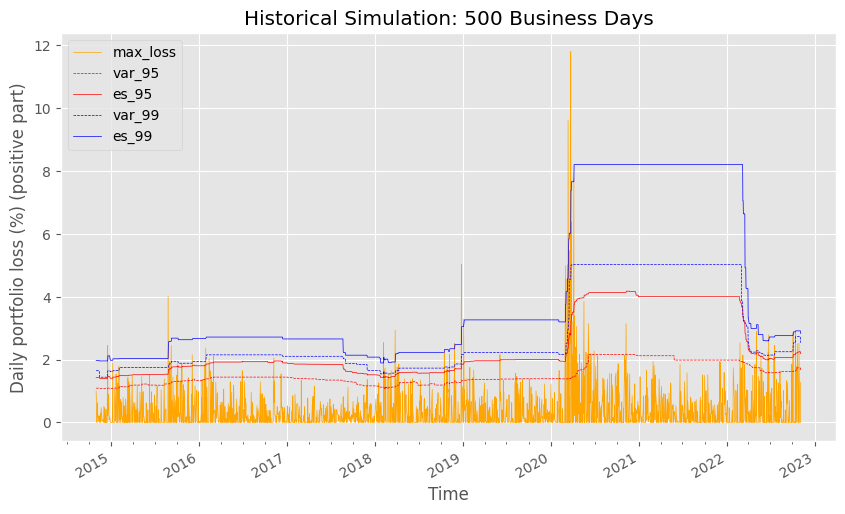

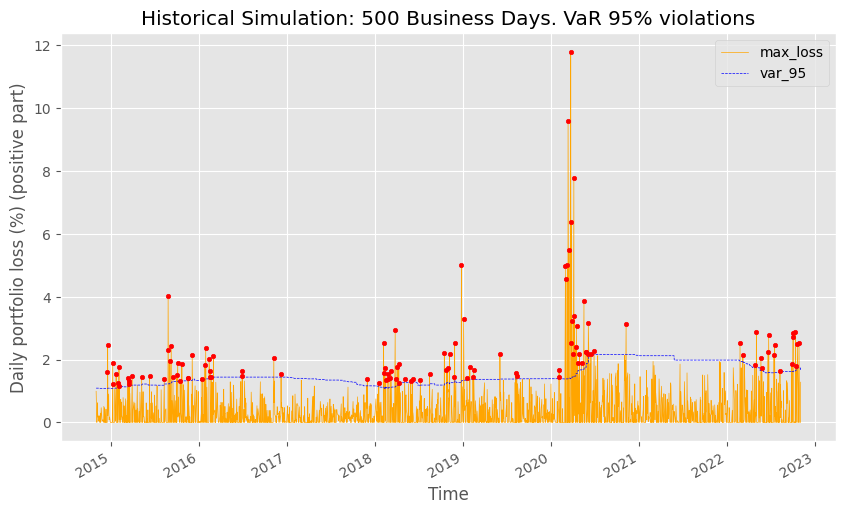

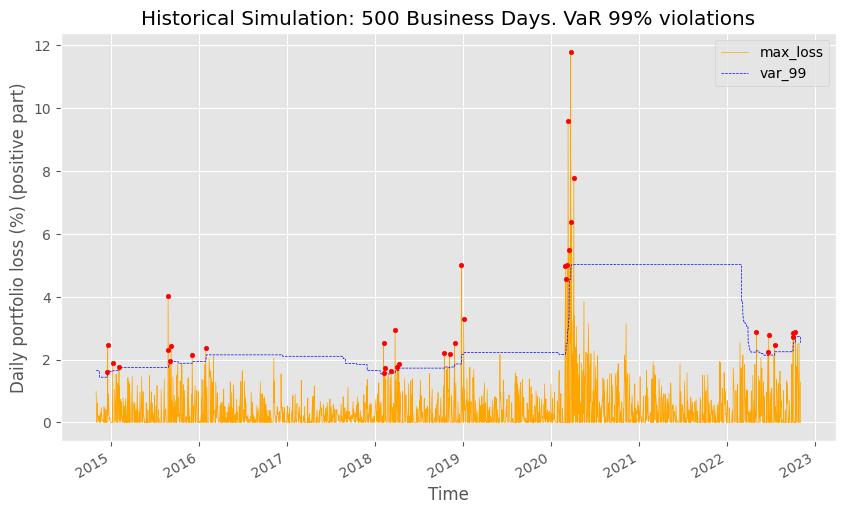

Violations 95%: 119, 5.90%
Violations 99%: 37, 1.83%


In [4]:
df = get_q2_data()

df['var_95'] = df['loss'].rolling(500).apply(lambda x: np.quantile(x, 0.95)).shift(1)
df['var_99'] = df['loss'].rolling(500).apply(lambda x: np.quantile(x, 0.99)).shift(1)

df['es_95'] = rolling_apply(vc.es, 501, df['loss'].values, df['var_95'].values)
df['es_99'] = rolling_apply(vc.es, 501, df['loss'].values, df['var_99'].values)
df_a = df.copy()

plotting.print_viols_and_plot(df_a, title='Historical Simulation: 500 Business Days')

# Q2 b)

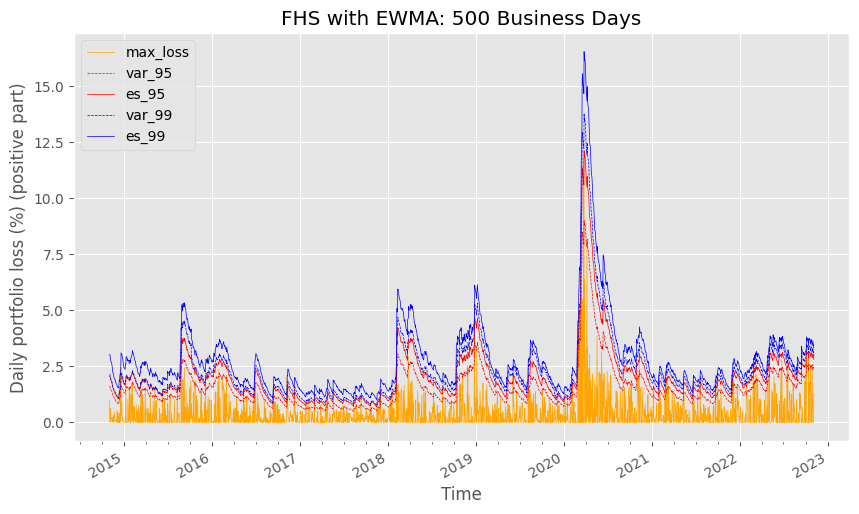

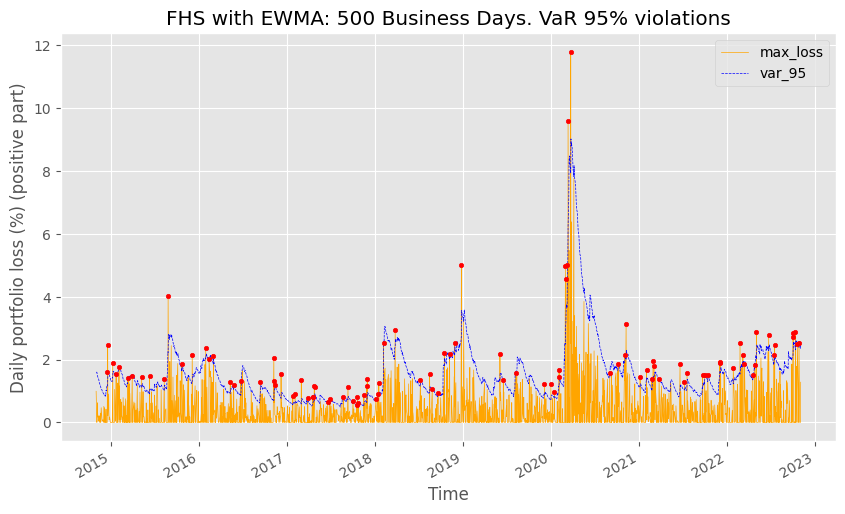

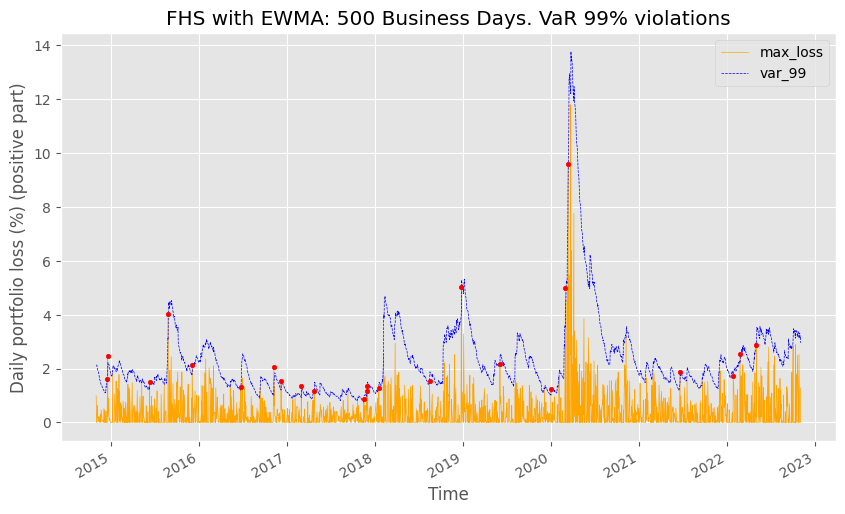

Violations 95%: 102, 5.05%
Violations 99%: 24, 1.19%


In [5]:
df = get_q2_data()

df['std_forc'] = 0

alpha = 0.06
for i in range(2, len(df)):
    df.iloc[i, 4] = np.sqrt(alpha*(df.iloc[i-1,2]**2) + (1-alpha)*(df.iloc[i-1,4]**2))


df['z_t'] = df['loss']/df['std_forc']
df.replace([np.inf, -np.inf], 0, inplace=True)

# shift 1 as quartile needs the n previous
df['q_95'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.95)).shift(1)
df['q_99'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.99)).shift(1)

df['es_95_z_t'] = rolling_apply(vc.es, 501, df['z_t'].values, df['q_95'].values)
df['es_99_z_t'] = rolling_apply(vc.es, 501, df['z_t'].values, df['q_99'].values)



df['var_95'] = df['q_95']*df['std_forc']
df['var_99'] = df['q_99']*df['std_forc']
df['es_95'] = df['std_forc']*df['es_95_z_t']
df['es_99'] = df['std_forc']*df['es_99_z_t']

df_b = df.copy()
plotting.print_viols_and_plot(df_b, title="FHS with EWMA: 500 Business Days")

# Q2 c)

In [6]:
df = get_q2_data()

df['var_95']= df['loss'].rolling(500).apply(vc.garch_var, kwargs=dict(alpha=0.95)).shift(1)
df['es_95']= df['loss'].rolling(500).apply(vc.garch_es, kwargs=dict(alpha=0.95)).shift(1)

df['var_99']= df['loss'].rolling(500).apply(vc.garch_var, kwargs=dict(alpha=0.99)).shift(1)
df['es_99']= df['loss'].rolling(500).apply(vc.garch_es, kwargs=dict(alpha=0.99)).shift(1)

df_c = df.copy()
# takes ~3m

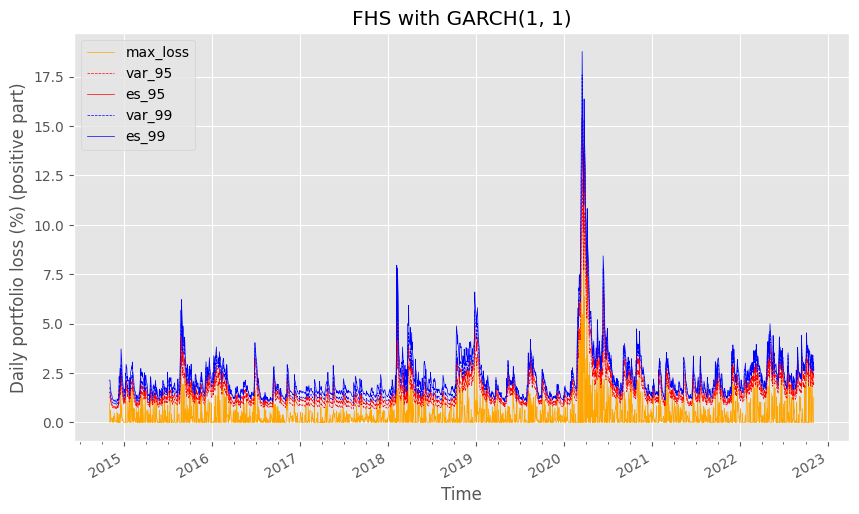

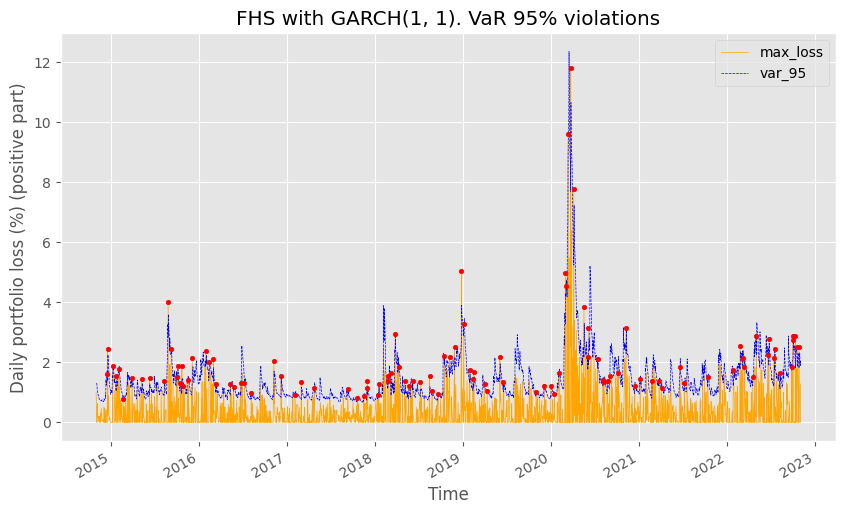

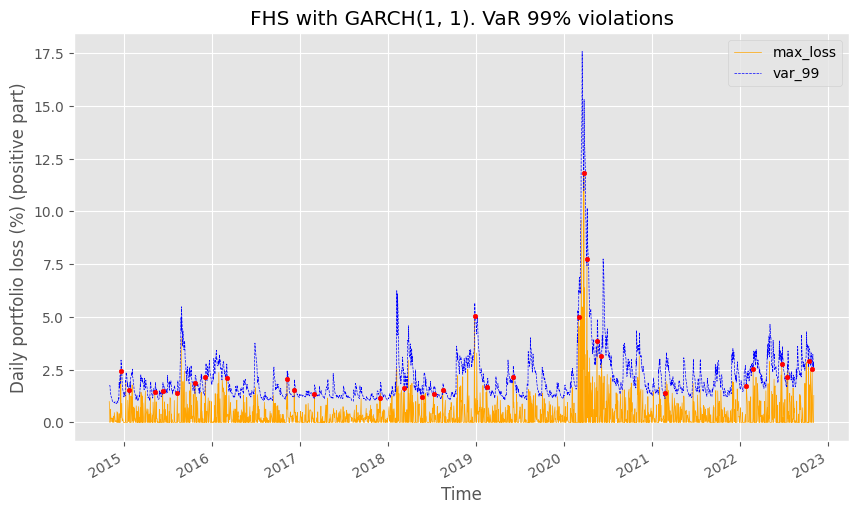

Violations 95%: 109, 5.40%
Violations 99%: 31, 1.54%


In [7]:
plotting.print_viols_and_plot(df_c, title = "FHS with GARCH(1, 1)")

# Backtesting

In [8]:
backtesting_df = pd.concat(
        [get_stats(df_a, "Historical Simulation"),
        get_stats(df_b, "Historical Simulation (EWMA)"),
        get_stats(df_c, "FHS with Garch")]
        ).reset_index(drop=True)
backtesting_df

,Title,Alpha,Violations (exp),LR_uc,LR_uc - p,LR_joint,LR_joint - p,ES - p
0,Historical Simulation,0.95,119 (100.9),3.240,0.07187,11.228,0.00365,0.10098
1,Historical Simulation,0.99,37 (20.2),11.363,0.00075,30.923,0.00000,0.04133
2,Historical Simulation (EWMA),0.95,102 (100.9),0.013,0.91070,0.032,0.98424,0.42424
3,Historical Simulation (EWMA),0.99,24 (20.2),0.689,0.40662,2.503,0.28613,0.91511
4,FHS with Garch,0.95,109 (100.9),0.668,0.41382,3.242,0.19772,0.00632
5,FHS with Garch,0.99,31 (20.2),5.035,0.02484,11.049,0.00399,0.34402
